# Practical Deep Learning for Coders, v3

# Lesson6_rossmann

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from fastai.tabular import *

# Rossmann
# 连锁店销量预估

## Data preparation 数据准备

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:<br><br>
为了从Kaggle竞赛数据集中创建经过特征工程处理的train_clean和test_clean，运行`rossman_data_clean.ipynb`，其中一个处理时间序列数据的重要步骤如下：

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

In [ ]:
path = Config().data_path()/'rossmann'
train_df = pd.read_pickle(path/'train_clean')

In [ ]:
train_df.head().T

0           1                   2  \
index                               0           1                   2   
Store                               1           2                   3   
DayOfWeek                           5           5                   5   
Date                       2015-07-31  2015-07-31          2015-07-31   
Sales                            5263        6064                8314   
Customers                         555         625                 821   
Open                                1           1                   1   
Promo                               1           1                   1   
StateHoliday                    False       False               False   
SchoolHoliday                       1           1                   1   
Year                             2015        2015                2015   
Month                               7           7                   7   
Week                               31          31                  31   
Day                                31          31                  31   
Dayofweek                           4           4                   4   
Dayofyear                         212         212                 212   
Is_month_end                     True        True                True   
Is_month_start                  False       False               False   
Is_quarter_end                  False       False               False   
Is_quarter_start                False       False               False   
Is_year_end                     False       False               False   
Is_year_start                   False       False               False   
Elapsed                    1438300800  1438300800          1438300800   
StoreType                           c           a                   a   
Assortment                          a           a                   a   
CompetitionDistance              1270         570               14130   
CompetitionOpenSinceMonth           9          11                  12   
CompetitionOpenSinceYear         2008        2007                2006   
Promo2                              0           1                   1   
Promo2SinceWeek                     1          13                  14   
...                               ...         ...                 ...   
Min_Sea_Level_PressurehPa        1015        1017                1017   
Max_VisibilityKm                   31          10                  31   
Mean_VisibilityKm                  15          10                  14   
Min_VisibilitykM                   10          10                  10   
Max_Wind_SpeedKm_h                 24          14                  14   
Mean_Wind_SpeedKm_h                11          11                   5   
Max_Gust_SpeedKm_h                NaN         NaN                 NaN   
Precipitationmm                     0           0                   0   
CloudCover                          1           4                   2   
Events                            Fog         Fog                 Fog   
WindDirDegrees                     13         309                 354   
StateName                      Hessen  Thueringen  NordrheinWestfalen   
CompetitionOpenSince       2008-09-15  2007-11-15          2006-12-15   
CompetitionDaysOpen              2510        2815                3150   
CompetitionMonthsOpen              24          24                  24   
Promo2Since                1900-01-01  2010-03-29          2011-04-04   
Promo2Days                          0        1950                1579   
Promo2Weeks                         0          25                  25   
AfterSchoolHoliday                  0           0                   0   
BeforeSchoolHoliday                 0           0                   0   
AfterStateHoliday                  57          67                  57   
BeforeStateHoliday                  0           0                   0   
AfterPromo                          0           0                   0   
BeforePromo          

In [ ]:
n = len(train_df); n

844338

### Experimenting with a sample 样例数据实验

In [ ]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [ ]:
small_train_df.head()

Store  DayOfWeek    PromoInterval  CompetitionDistance  Mean_Humidity  \
267     268          5              NaN               4520.0             67   
604     606          5              NaN               2260.0             61   
983     986          5  Feb,May,Aug,Nov                620.0             61   
1636    525          4              NaN               1870.0             55   
2348    123          3              NaN              16760.0             50   

      Sales  
267    7492  
604    7187  
983    7051  
1636   9673  
2348  10007

In [ ]:
small_test_df.head()

Store  DayOfWeek     PromoInterval  CompetitionDistance  \
420510    829          3               NaN                110.0   
420654    973          3   Jan,Apr,Jul,Oct                330.0   
420990    194          2   Feb,May,Aug,Nov              16970.0   
421308    512          2  Mar,Jun,Sept,Dec                590.0   
421824   1029          2               NaN               1590.0   

        Mean_Humidity  Sales  
420510             55   6802  
420654             59   6644  
420990             55   4720  
421308             72   6248  
421824             64   8004

In [ ]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [ ]:
small_test_df.head()

Store DayOfWeek     PromoInterval  CompetitionDistance  \
420510     NaN         3               NaN                110.0   
420654   973.0         3   Jan,Apr,Jul,Oct                330.0   
420990     NaN         2   Feb,May,Aug,Nov              16970.0   
421308   512.0         2  Mar,Jun,Sept,Dec                590.0   
421824  1029.0         2               NaN               1590.0   

        Mean_Humidity  Sales  
420510             55   6802  
420654             59   6644  
420990             55   4720  
421308             72   6248  
421824             64   8004

In [ ]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [ ]:
small_train_df['PromoInterval'].cat.codes[:5]

267    -1
604    -1
983     0
1636   -1
2348   -1
dtype: int8

In [ ]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [ ]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

Store DayOfWeek PromoInterval  CompetitionDistance  Mean_Humidity  \
185749   622         2           NaN               2300.0             93   

        Sales  CompetitionDistance_na  
185749   4508                    True

### Preparing full data set 准备全部数据集

In [ ]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [ ]:
len(train_df),len(test_df)

(844338, 41088)

In [ ]:
procs=[FillMissing, Categorify, Normalize]

In [ ]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [ ]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [ ]:
test_df['Date'].min(), test_df['Date'].max()

('2015-08-01', '2015-09-17')

In [ ]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [ ]:
valid_idx = range(cut)

In [ ]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [ ]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [ ]:
doc(FloatList)

## Model 模型

In [ ]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [ ]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [ ]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [ ]:
len(data.train_ds.cont_names)

16

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


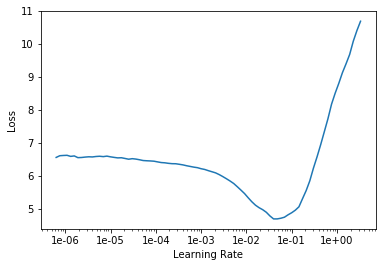

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

In [ ]:
learn.save('1')

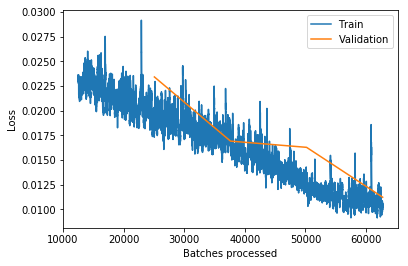

In [ ]:
learn.recorder.plot_losses(last=-1)

In [ ]:
learn.load('1');

In [ ]:
learn.fit_one_cycle(5, 3e-4)

In [ ]:
learn.fit_one_cycle(5, 3e-4)

(10th place in the competition was 0.108)

In [ ]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)